<a href="https://colab.research.google.com/github/TomPham204/thesis/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

import numpy as np

In [ ]:
data_dir = './drive/MyDrive/TrashDataset/'
test_dir = './drive/MyDrive/TrashDatasetTest'
weight_dir = './drive/MyDrive/TrashModel/'
batch_size = 64
image_size = (300, 300)
class_num = 5

**Data loading & augmentation**

In [ ]:
train_datagen  = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1],
    validation_split=0.18
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=2
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=2
)

Found 3648 images belonging to 5 classes.
Found 798 images belonging to 5 classes.
Found 786 images belonging to 5 classes.


**Model initialization**

In [ ]:
base_model = MobileNetV2(weights='imagenet', classes=class_num, include_top=False, input_shape=(300, 300, 3))

blocks_to_freeze = len(base_model.layers) * 2 // 3

for layer in base_model.layers[:blocks_to_freeze]:
    layer.trainable = False

# custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dropout(0.4)(x)

# classifier output layer
predictions = Dense(class_num, activation='softmax', kernel_regularizer=regularizers.l2(0.005))(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# optimizer
optim = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def learning_rate_schedule(epoch, lr=0.01):
    if (epoch < 10 or lr <= 0.0001):
        return lr
    else:
        return lr*0.9

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

model_checkpoint = ModelCheckpoint(weight_dir+'trash_classification_model-resume.h5', save_best_only=True, save_weights_only=False)
checkpoints=[model_checkpoint, early_stopping, lr_scheduler]

**Training**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=25,
    callbacks=checkpoints
)

Epoch 1/25
57/57 [==============================] - 897s 16s/step - loss: 0.7987 - accuracy: 0.9989 - val_loss: 1.1802 - val_accuracy: 0.8854 - lr: 5.0000e-04
Epoch 2/25
57/57 [==============================] - 850s 15s/step - loss: 0.7933 - accuracy: 0.9984 - val_loss: 1.1800 - val_accuracy: 0.8906 - lr: 5.0000e-04
Epoch 3/25
57/57 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.9981 

**Plotting**

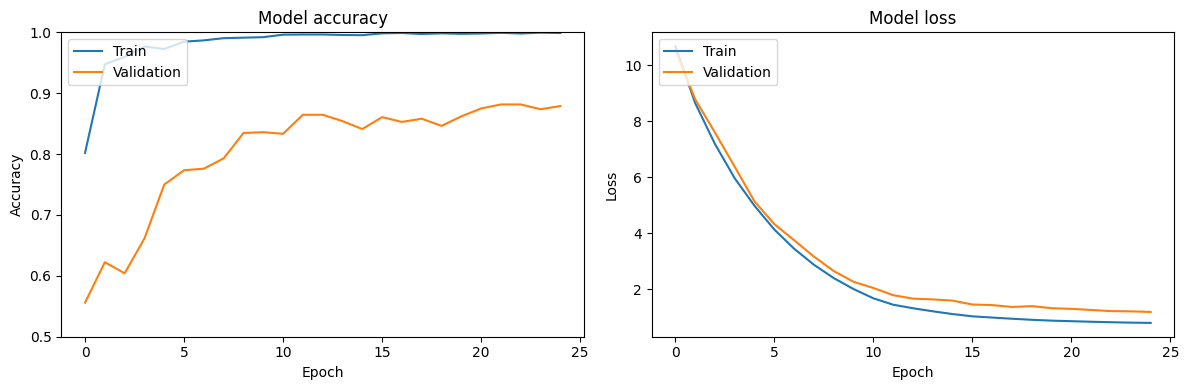

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0.5, 1)
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title='Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

test_steps = len(test_generator)
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_labels)

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

**Save trained weight**

In [ ]:
from datetime import date, datetime
model.save(weight_dir+f'trash-{date.today()}-{datetime.now().strftime("%H-%M")}.h5')

**If !!checkpoint from last save**

In [ ]:
from datetime import date

try:
  saved_model = tf.keras.models.load_model('trash_classification_model.h5') | None

  if(saved_model != None):
    history = saved_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=25,
        callbacks=checkpoints
    )
    saved_model.save(f'trash_classification_model-{date.today()}.h5')
except:
  print('No saved weight')

No saved weight


**Appendix**

Architecture

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                                             